### Performance of Eitlem at different sequence similarity levels between test dataset and training dataset.

In [7]:
import torch
import sys
import os
sys.path.append("../Code/")
from predictor import predict
from tools import metric, getPairInfo

## 指定测试的动力学参数类型
kineticsType = 'kcat'
molType = 'MACCSKeys'

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^8}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

modelPath = {
    'kcat':"../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
    'km':"../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802",
    'kkm':"../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896"
}

## 加载目标测试集
test_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TestPairInfo")
train_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TrainPairInfo")
## 加载seq和smiles映射
index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

'''
## get seqs identity
!../Code/getsimi.sh
'''


sim_index = torch.load(f"../Data/{kineticsType.upper()}/all_seq_Indentity")
sim_index = {k:max(v) for k, v in sim_index.items()}

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set



# 去除测试集中出现在训练集的样本
if kineticsType == 'kcat':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
elif kineticsType == 'km':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
else :
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

test_pair_info = []
for item in test_pair:
    if f"{index_seq[item[0]]}_{index_smiles[item[1]]}" not in ExcludeSet:
        test_pair_info.append(item)

print(f"|{'Range':8^}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
# 0-40%
Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    getPairInfo(0, 0.4, sim_index, test_pair_info),
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("0-40%",**metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    getPairInfo(0.4, 0.8, sim_index, test_pair_info),
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("40-80%",**metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    getPairInfo(0.8, 0.99, sim_index, test_pair_info),
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("80-99%",**metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    getPairInfo(0.99, 1, sim_index, test_pair_info),
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("99-100%", **metric(Pre, Real, True))

|Range| MAE  | rmse |  r2  |  r   |p_value |samples |
log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


| 0-40%  |0.969 |1.279 |0.375 |0.656 | 0.000  |   83   |
log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


| 40-80% |0.692 |1.078 |0.456 |0.679 | 0.000  |   72   |
log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


| 80-99% |0.880 |1.311 |0.763 |0.887 | 0.000  |   26   |
log10:True molType:MACCSKeys


100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

|99-100% |0.580 |0.962 |0.664 |0.823 | 0.000  |  347   |


### Eitlem's predictive performance tests are excluded after samples from the test set appear in the other two type's training datasets

In [2]:
import sys
sys.path.append("../Code/")
from tools import metric
import numpy as np
import torch    
import pandas as pd
from predictor import predict
# MACCSKeys
modelPath = {
    'kcat_1':'../Weights/KCAT/iter1_trainR2_0.9166_devR2_0.6752_RMSE_0.8763_MAE_0.5617',
    'kcat_8':"../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
    'km_1':'../Weights/KM/iter1_trainR2_0.8980_devR2_0.6307_RMSE_0.7941_MAE_0.5537',
    'km_8':"../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802",
    'kkm_1':"../Weights/KKM/BaseKKmPredictor_trainR2_0.8425_devR2_0.5885_RMSE_1.1471_MAE_0.8049",
    "kkm_8":"../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896"
}

def err(x, y):
    x = np.array(x)
    y = np.array(y)
    return np.abs(x-y)

results = {'kcat':[], 'km':[], 'kkm':[]}
AEData = {'kcat':[], 'km':[], 'kkm':[]}

index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set

for KineticsType in ['kcat', 'km', 'kkm']:
    # 加载kcat或Km测试集
    TestPairInfo = torch.load(f"../Data/{KineticsType.upper()}/{KineticsType.upper()}TestPairInfo")
    # 去除重复样本
    if KineticsType == 'kcat':
        ExcludeSet = get_set(KineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
    elif KineticsType == 'km':
        ExcludeSet = get_set(KineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
    else:
        ExcludeSet = get_set(KineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

    pureTestPairInfo = []
    for item in TestPairInfo:
        seq = index_seq[item[0]]
        smiles = index_smiles[item[1]]
        if f"{seq}_{smiles}" not in ExcludeSet:
            pureTestPairInfo.append(item)

    
    iter1Real, iter1Pre = predict(
                    KineticsType.upper(),
                    modelPath[KineticsType+'_1'],
                    pureTestPairInfo,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    KineticsType != 'kkm',
                    torch.device("cuda:1"),
                    "MACCSKeys"
            )
    res = metric(iter1Pre, iter1Real, KineticsType != 'kkm')
    res['type'] = 'iter1'
    results[KineticsType].append(res)
    iter8Real, iter8Pre = predict(
                    KineticsType.upper(),
                    modelPath[KineticsType+'_8'],
                    pureTestPairInfo,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
            )
    res = metric(iter8Pre, iter8Real, True)
    res['type'] = 'iter8'
    results[KineticsType].append(res)
    
    AEData[KineticsType].append(err(iter1Pre, iter1Real))
    AEData[KineticsType].append(err(iter8Pre, iter8Real))

AEData = pd.DataFrame(AEData)
for k, v in results.items():
    print(k)
    print(pd.DataFrame(v))

log10:True molType:MACCSKeys


100%|██████████| 26/26 [00:05<00:00,  4.90it/s]


log10:True molType:MACCSKeys


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


log10:True molType:MACCSKeys
F


100%|██████████| 20/20 [00:05<00:00,  3.43it/s]


log10:True molType:MACCSKeys
F


100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


log10:False molType:MACCSKeys


100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


log10:True molType:MACCSKeys


100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

kcat
        MAE      rmse        r2         r  p_value  samples   type
0  0.569577  0.885017  0.679210  0.826321      0.0     2555  iter1
1  0.509600  0.824657  0.721475  0.851507      0.0     2555  iter8
km
        MAE      rmse        r2         r  p_value  samples   type
0  0.558073  0.806350  0.621851  0.793407      0.0     1975  iter1
1  0.500965  0.727776  0.691957  0.833798      0.0     1975  iter8
kkm
        MAE      rmse        r2         r        p_value  samples   type
0  0.829926  1.225867  0.518582  0.737181   1.051320e-74      429  iter1
1  0.663203  0.998852  0.680377  0.826997  7.482903e-109      429  iter8


### Eitlem performance test under different enzyme-substrate similarity levels between test dataset and training dataset.

In [5]:
import torch
import sys
sys.path.append("../Code/")
from predictor import predict
from tools import metric
import os
## 指定测试的动力学参数类型
kineticsType = 'kcat'
molType = 'MACCSKeys'

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^8}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

modelPath = {
    'kcat':"../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
    'km':"../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802",
    'kkm':"../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896"
}
## 加载目标测试集
test_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TestPairInfo")
train_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TrainPairInfo")
## 加载seq和smiles映射
index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

## 获取底物相似性
torch.save(test_pair, "./query")
torch.save(train_pair, "./search")
cmd = f"python ../Code/calculate_similarity.py -m True -q ./query -s ./search -f ../Data/Feature/index_smiles"
os.system(cmd)
sim_index = torch.load("./molSimiResults")
seq_sim_index = torch.load(f"../Data/{kineticsType.upper()}/all_seq_Indentity")
seq_sim_index = {k:max(v) for k, v in seq_sim_index.items()}
def get_range_pair(low, high, m_sim_index, s_sim_index, pair):
    pairInfo = []
    for item in pair:
        try:
            t  = s_sim_index[item[0]]
        except:
            t = 1.0
        score = (t+m_sim_index[item[1]])/2
        if score >= low and score < high:
            pairInfo.append(item)
    return pairInfo

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set

if kineticsType == 'kcat':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
elif kineticsType == 'km':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
else :
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

test_pair_info = []
for item in test_pair:
    if f"{index_seq[item[0]]}_{index_smiles[item[1]]}" not in ExcludeSet:
        test_pair_info.append(item)

print(f"|{'Range':8^}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    get_range_pair(0.4, 0.8, sim_index, seq_sim_index,test_pair_info),
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("40-80%",**metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    get_range_pair(0.8, 0.99, sim_index, seq_sim_index,test_pair_info),
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("80-99%", **metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    get_range_pair(0.99, 1, sim_index, seq_sim_index,test_pair_info),
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("99-100%", **metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    [ item for item in test_pair_info if (sim_index[item[1]] + (seq_sim_index[item[0]] if seq_sim_index.get(item[0]) is not None else 1.0) )/2 != 1],
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("not Same", **metric(Pre, Real, True))

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    [ item for item in test_pair_info if (sim_index[item[1]] + (seq_sim_index[item[0]] if seq_sim_index.get(item[0]) is not None else 1.0))/2 == 1],
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
printf("Same", **metric(Pre, Real, True))

326 query entrys 
 5731 search entrys
|Range| MAE  | rmse |  r2  |  r   |p_value |samples |
log10:True molType:MACCSKeys


100%|██████████| 2/2 [00:03<00:00,  1.69s/it]


| 40-80% |0.844 |1.140 |0.461 |0.703 | 0.000  |  134   |
log10:True molType:MACCSKeys


100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


| 80-99% |0.713 |1.063 |0.641 |0.806 | 0.000  |  164   |
log10:True molType:MACCSKeys


100%|██████████| 4/4 [00:03<00:00,  1.08it/s]


|99-100% |0.578 |0.954 |0.686 |0.835 | 0.000  |  360   |
log10:True molType:MACCSKeys


100%|██████████| 7/7 [00:06<00:00,  1.12it/s]


|not Same|0.666 |1.022 |0.647 |0.806 | 0.000  |  658   |
log10:True molType:MACCSKeys


100%|██████████| 19/19 [00:06<00:00,  2.82it/s]

|  Same  |0.455 |0.744 |0.755 |0.871 | 0.000  |  1897  |


### Performance testing of different machine learning baseline models

In [2]:
import math
import torch
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys

def load_dataset(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    index_smiles = torch.load(f"../Data/Feature/index_smiles")
    features = []
    labels = []
    for item in pair_info:
        proteins_embeding = torch.load(f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/{item[0]}.pt").mean(dim=0).numpy()
        smiles_embeding = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(index_smiles[item[1]])))
        features.append(np.concatenate([proteins_embeding, smiles_embeding], axis=-1))
        labels.append(math.log10(item[2]))
    return np.stack(features, axis=0), np.array(labels)

#### 1.LinearRegression

{'MAE': 0.9052224205294862, 'rmse': 1.198489787483746, 'r2': 0.3924756668298963, 'r': 0.6283032804615011, 'p_value': 0.0, 'samples': 3444}


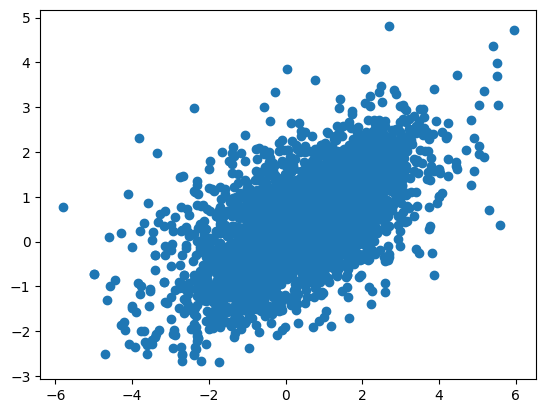

In [3]:
from sklearn.linear_model import LinearRegression as LR
import matplotlib.pyplot as plt
import sys
sys.path.append("../Code/")
from tools import metric
kineticsType = 'KCAT'
train_x, train_y = load_dataset(kineticsType, 'Train')
test_x, test_y = load_dataset(kineticsType, 'Test')
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 2.RidgeRegression

{'MAE': 0.9040110275912254, 'rmse': 1.1955172900893478, 'r2': 0.3954854964694584, 'r': 0.6298128179735476, 'p_value': 0.0, 'samples': 3444}


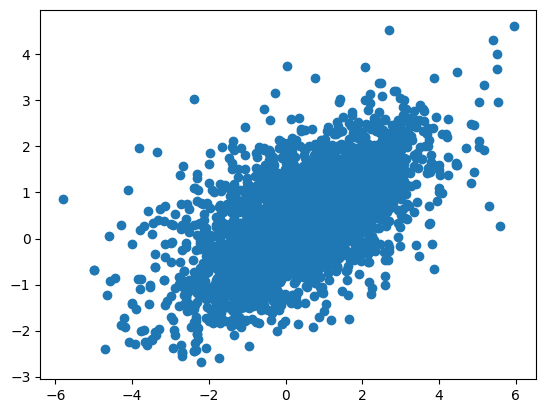

In [4]:
from sklearn.linear_model import Ridge as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 3.LassoRegression

{'MAE': 1.2281067435035107, 'rmse': 1.5385678229372992, 'r2': -0.0012171798763003228, 'r': nan, 'p_value': nan, 'samples': 3444}


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


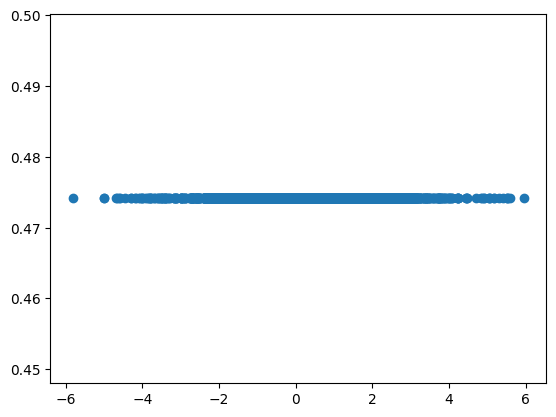

In [5]:
from sklearn.linear_model import Lasso as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 4.Bayesian Ridge Regression

{'MAE': 0.9068503940616359, 'rmse': 1.1952970995185386, 'r2': 0.3957081551239763, 'r': 0.6292887446924599, 'p_value': 0.0, 'samples': 3444}


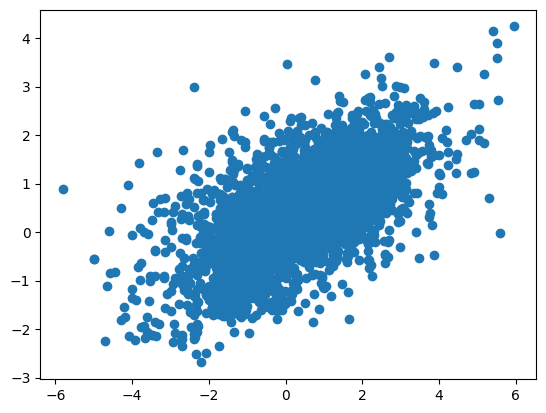

In [6]:
from sklearn.linear_model import BayesianRidge as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 5.ElasticNetRegression

{'MAE': 1.2281067435035107, 'rmse': 1.5385678229372992, 'r2': -0.0012171798763003228, 'r': nan, 'p_value': nan, 'samples': 3444}


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


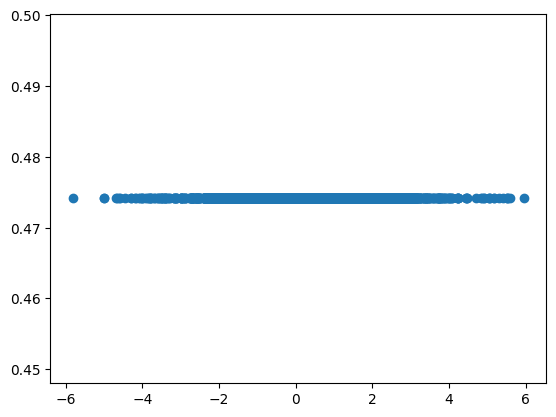

In [7]:
from sklearn.linear_model import ElasticNet as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 6.Decision Tree

{'MAE': 0.6633600425940442, 'rmse': 1.1554189049353922, 'r2': 0.4353570105136536, 'r': 0.7186237938715782, 'p_value': 0.0, 'samples': 3444}


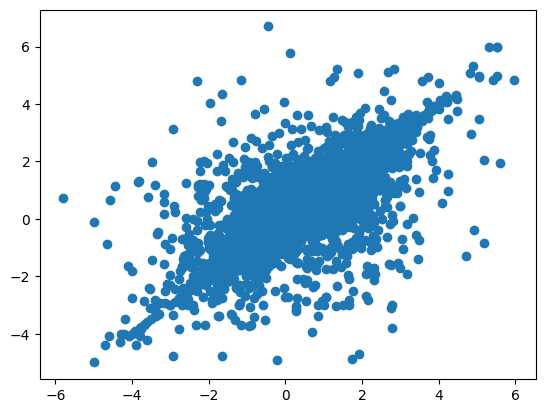

In [8]:
from sklearn.tree import DecisionTreeRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 7.Support Vector Regression

{'MAE': 0.9808605745741366, 'rmse': 1.2974760274332757, 'r2': 0.2879775503616676, 'r': 0.5431497223710925, 'p_value': 1.3165361277833554e-263, 'samples': 3444}


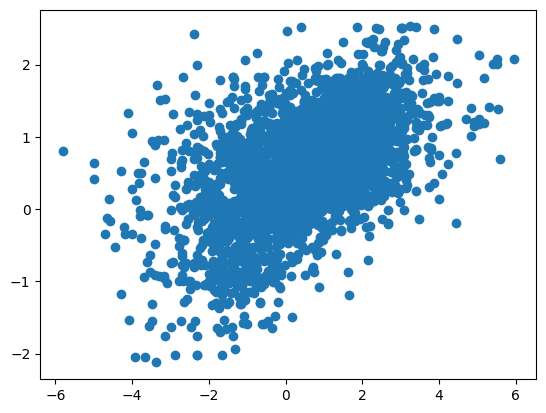

In [9]:
from sklearn.svm import SVR as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 8. KNeighborsRegression

{'MAE': 0.7328248346696218, 'rmse': 1.0516324687186651, 'r2': 0.5322401143800886, 'r': 0.7352027011363124, 'p_value': 0.0, 'samples': 3444}


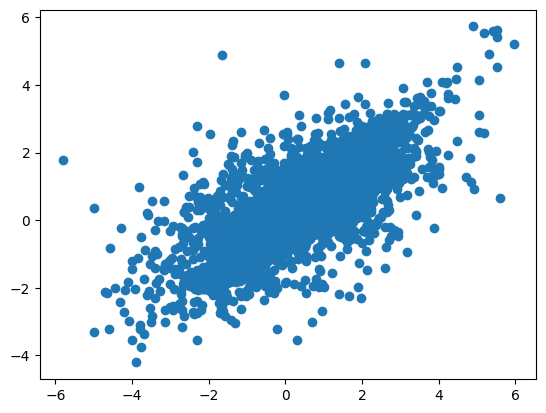

In [10]:
from sklearn.neighbors import KNeighborsRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 9. RandomForestRegression

{'MAE': 0.5831911882374995, 'rmse': 0.8957191528280363, 'r2': 0.6606571340722488, 'r': 0.8130091144049889, 'p_value': 0.0, 'samples': 3444}


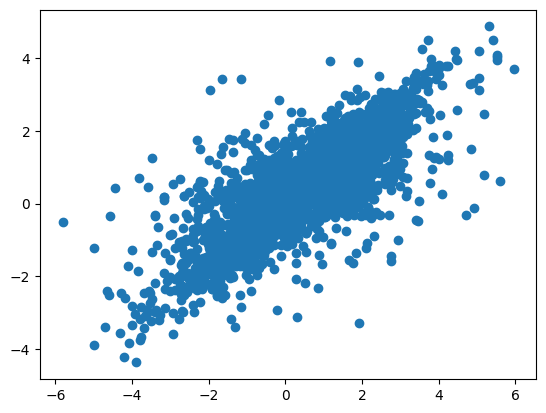

In [11]:
from sklearn.ensemble import RandomForestRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 10. GradientBoostRegression

{'MAE': 0.9601096793839747, 'rmse': 1.2362271679154548, 'r2': 0.3536145540642468, 'r': 0.6271879594383568, 'p_value': 0.0, 'samples': 3444}


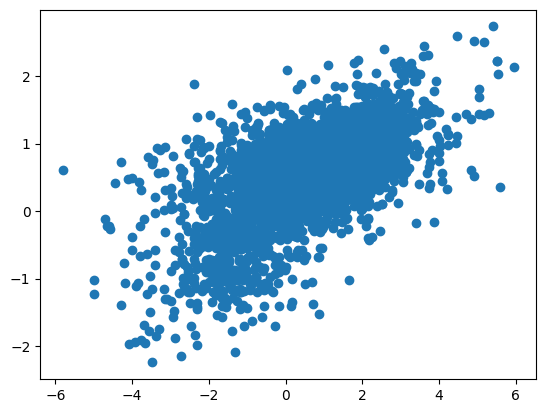

In [12]:
from sklearn.ensemble import GradientBoostingRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 11. AdaBoostRegression

{'MAE': 1.1442378816090464, 'rmse': 1.415141897019032, 'r2': 0.15297743553039356, 'r': 0.4399729586812283, 'p_value': 4.842299408305194e-163, 'samples': 3444}


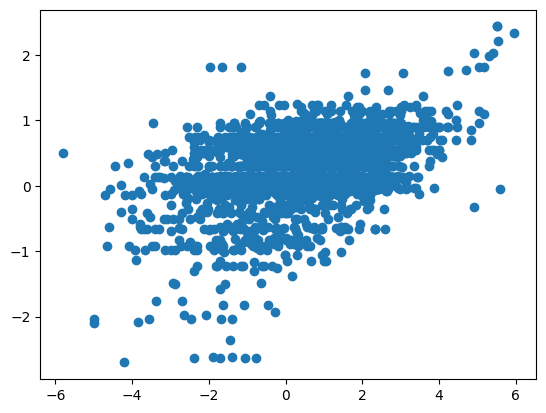

In [13]:
from sklearn.ensemble import AdaBoostRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 12. BaggingRegression

{'MAE': 0.6139793388343844, 'rmse': 0.942959724067911, 'r2': 0.6239190901205705, 'r': 0.791053401305402, 'p_value': 0.0, 'samples': 3444}


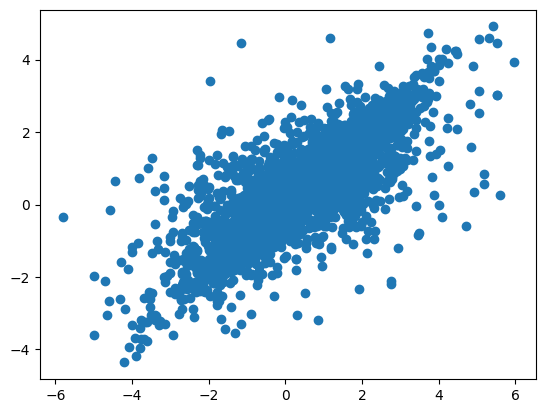

In [14]:
from sklearn.ensemble import BaggingRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 13. XGBoostRegression

{'MAE': 1.0161072938417022, 'rmse': 1.3032582941598536, 'r2': 0.2816170817733238, 'r': 0.5666209177166285, 'p_value': 9.174589100912473e-292, 'samples': 3444}


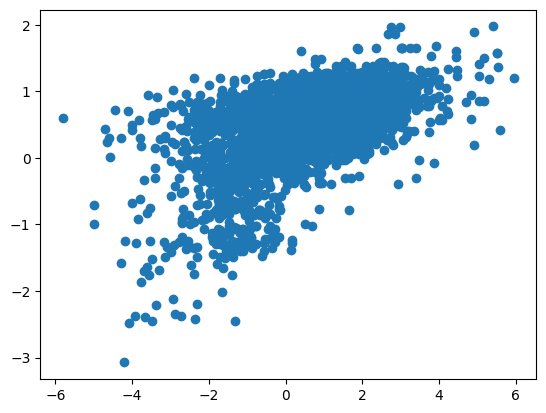

In [15]:
from xgboost import XGBRFRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 14 LGBMRegression

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326710
[LightGBM] [Info] Number of data points in the train set: 30985, number of used features: 1435
[LightGBM] [Info] Start training from score 0.474111
{'MAE': 0.777509123536341, 'rmse': 1.0361581543435372, 'r2': 0.5459046022808263, 'r': 0.7475630855085718, 'p_value': 0.0, 'samples': 3444}


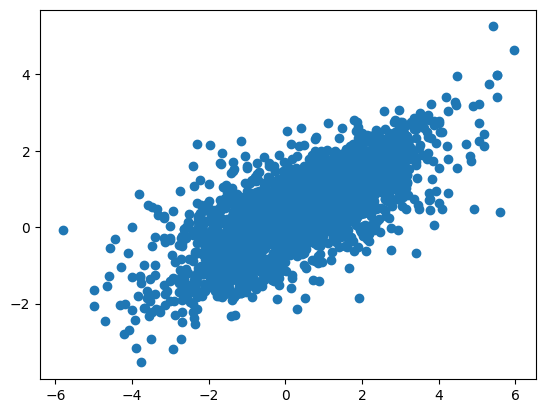

In [16]:
from lightgbm import LGBMRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 15. Extra Tree

{'MAE': 0.5491150085884099, 'rmse': 0.9067090048770536, 'r2': 0.6522790481277005, 'r': 0.8103243883272995, 'p_value': 0.0, 'samples': 3444}


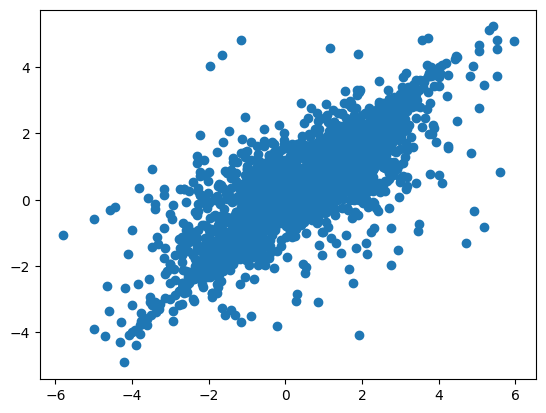

In [17]:
from sklearn.ensemble import ExtraTreesRegressor as LR
regr = LR()
regr.fit(train_x, train_y)
y_pred = regr.predict(test_x)
print(metric(y_pred, test_y, True))
plt.scatter(test_y, y_pred)

#### 16.EITLEM-Base

log10:True molType:MACCSKeys


100%|██████████| 35/35 [00:09<00:00,  3.53it/s]

{'MAE': 0.5613725056668569, 'rmse': 0.876334029840209, 'r2': 0.6751862874594141, 'r': 0.823833604098756, 'p_value': 0.0, 'samples': 3444}


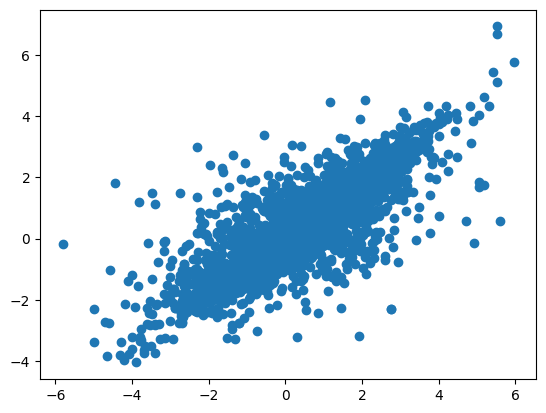

In [18]:
from predictor import predict
test_pair = torch.load(f"../Data/{kineticsType}/{kineticsType}TestPairInfo")
index_seq = torch.load(f"../Data/{kineticsType}/index_seq")
index_smiles = torch.load(f"../Data/{kineticsType}/index_smiles")

modelPath = {
    'KCAT':'../Weights/KCAT/iter1_trainR2_0.9166_devR2_0.6752_RMSE_0.8763_MAE_0.5617',
    'KM':'../Weights/KM/iter1_trainR2_0.8980_devR2_0.6307_RMSE_0.7941_MAE_0.5537',
    'KKM':'../Weights/KKM/BaseKKmPredictor_trainR2_0.8425_devR2_0.5885_RMSE_1.1471_MAE_0.8049'
}
y_test, y_pred = predict(
    kineticsType,
    modelPath[kineticsType],
    test_pair,
    f"../Data/{kineticsType}/esm1v_t33_650M_UR90S_1_embeding_1280/",
    f"../Data/{kineticsType}/index_smiles",
    True,
    torch.device("cuda:1"),
    'MACCSKeys'
)
print(metric(y_pred, y_test, True))
plt.scatter(y_test, y_pred)

### Compared with UniKP

#### 1.Test UniKP on our test set

In [3]:
import sys
sys.path.append("../Code/")
import torch
from UniKP import UniKp_predictor
from build_vocab import WordVocab
from tools import getPairInfo

kineticsType = 'KCAT'

index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set

if kineticsType == 'KCAT':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
elif kineticsType == 'KM':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
else:
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')



train_pair = torch.load(f"../Data/{kineticsType}/{kineticsType}TrainPairInfo")
test_pair = torch.load(f"../Data/{kineticsType}/{kineticsType}TestPairInfo")
index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

exclude_test_pairinfo = []
for item in test_pair:
    seq = index_seq[item[0]]
    smiles = index_smiles[item[1]]
    if f"{seq}_{smiles}" not in ExcludeSet:
        exclude_test_pairinfo.append(item)

unikp_predictor = UniKp_predictor()

unikp_predictor.fit(train_pair, train_pair + test_pair, index_seq, index_smiles, kineticsType)


print(f"whole:{unikp_predictor.test(test_pair)}")
print(f"exclude:{unikp_predictor.test(exclude_test_pairinfo)}")

print("----Max sequence identity test-----")

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^8}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

sim_index = torch.load(f"../Data/{kineticsType.upper()}/all_seq_Indentity")
sim_index = {k:max(v) for k, v in sim_index.items()}

print(f"|{'Range':^8}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("0-40%",**unikp_predictor.test(getPairInfo(0,0.4, sim_index, exclude_test_pairinfo)))
printf("40-80%",**unikp_predictor.test(getPairInfo(0.4,0.8, sim_index, exclude_test_pairinfo)))
printf("80-99%",**unikp_predictor.test(getPairInfo(0.8,0.99, sim_index, exclude_test_pairinfo)))
printf("99-100%",**unikp_predictor.test(getPairInfo(0.99,1, sim_index, exclude_test_pairinfo)))

There are 30985 molecules. It will take a little time.
There are 3444 molecules. It will take a little time.
whole:{'MAE': 0.6074111605342364, 'rmse': 0.8859814044128351, 'r2': 0.6679953125057796, 'r': 0.8184112571616314, 'p_value': 0.0, 'samples': 3444}
There are 2555 molecules. It will take a little time.
exclude:{'MAE': 0.6176819453539125, 'rmse': 0.8973130968077749, 'r2': 0.6702340493894263, 'r': 0.8199636076648336, 'p_value': 0.0, 'samples': 2555}
----Max sequence identity test-----
| Range  | MAE  | rmse |  r2  |  r   |p_value |samples |
| 0-40%  |1.202 |1.533 |0.102 |0.445 | 0.000  |   83   |
| 40-80% |0.981 |1.221 |0.302 |0.609 | 0.000  |   72   |
| 80-99% |1.151 |1.658 |0.620 |0.823 | 0.000  |   26   |
There are 347 molecules. It will take a little time.
|99-100% |0.688 |1.012 |0.628 |0.801 | 0.000  |  347   |


### 2.Significance test

In [ ]:

import torch
import sys
sys.path.append("../Code/")
from predictor import predict
from tools import metric
import os
import math
import scipy.stats as stats

modelPath = {
    'kcat':"../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
    'km':"../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802",
    'kkm':"../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896"
}

Real, Pre = Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType.lower()}'],
                    exclude_test_pairinfo,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )

EITLEM_AE = [ abs(r-p) for r, p in zip(Real, Pre)]
x_test, y_test = unikp_predictor._load_dataset(exclude_test_pairinfo, unikp_predictor.index_seq, unikp_predictor.index_smiles)
y_pred = unikp_predictor.model.predict(x_test)
UniKP_AE = [ abs(r-p) for r, p in zip(y_pred, y_test)]
print(stats.wilcoxon(EITLEM_AE, UniKP_AE, alternative='two-sided'))
metric(Pre, Real, True)

### Test **Dlkcat method** on our dataset

#### 1. Dataprocess for DLkcat. Run the following code cell.

In [2]:
!python ../Code/DLkcat_dataprocess.py

#### 2. train DLkcat model. Run the following code cell.

In [3]:
!python ../Code/train_DLkcat.py

Training...
Epoch	Time(sec)	RMSE_train	R2_train	MAE_test	RMSE_test	R2_test
1	333.22867145203054	1.4438638177627627	0.10114233958004581	1.1072608820910113	1.410566722758674	0.15346132181807903
2	658.2202125908807	1.383145452585449	0.17515154807945388	1.1236716165466143	1.4174739368287128	0.1451504209362734
3	983.1968256798573	1.3601510272490307	0.2023493473244271	1.0732611968282546	1.3797321200100885	0.19006701323518882
4	1308.8597337761894	1.3475865647745586	0.21701795675676616	1.055700293199392	1.3647387980644525	0.20757418680040451
5	1632.6859610318206	1.3391426320372797	0.22679949409744915	1.0479746087350699	1.3527976280528475	0.22138062945674608
6	1957.5652428339235	1.3315304567455748	0.23556481797810858	1.0526332625309451	1.357212405815483	0.21629037746065882
7	2281.043088532053	1.3277992438756205	0.23984301388543605	1.046058865088277	1.3592403594902003	0.21394658190998095
8	2605.6162671479397	1.3234029476081723	0.24486838638916042	1.033864077021945	1.3524588690598154	0.2217705344

In [1]:
import sys
sys.path.append("../Code/")
import torch
from DLkcatTools import dlkcatPredict
test_pair = torch.load("../Data/KCAT/KCATTestPairInfo")
from tools import getPairInfo
from tools import metric

### The same setting as in the DLKcat paper
modelPath = "../Weights/DLkcat/all--radius2--ngram3--dim20--layer_gnn3--window11--layer_cnn3--layer_output3--lr1e-3--lr_decay0.5--decay_interval10--weight_decay1e-6--iteration50"
index_seq = torch.load("../Data/Feature/index_seq")
index_smiles = torch.load("../Data/Feature/index_smiles")
def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set
ExcludeSet = get_set("KCAT", 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
exclude_test_pairinfo = []
for item in test_pair:
    seq = index_seq[item[0]]
    smiles = index_smiles[item[1]]
    if f"{seq}_{smiles}" not in ExcludeSet:
        exclude_test_pairinfo.append(item)

print(f"whole:{metric(*dlkcatPredict(test_pair, modelPath))}")
print(f"exclude:{metric(*dlkcatPredict(exclude_test_pairinfo, modelPath))}")
print("----Max sequence identity test-----")

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^8}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

sim_index = torch.load(f"../Data/KCAT/all_seq_Indentity.pt")
sim_index = {k:max(v) for k, v in sim_index.items()}

print(f"|{'Range':^8}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("0-40%",**metric(*dlkcatPredict(getPairInfo(0,0.4, sim_index, exclude_test_pairinfo), modelPath)))
printf("40-80%",**metric(*dlkcatPredict(getPairInfo(0.4,0.8, sim_index, exclude_test_pairinfo), modelPath)))
printf("80-99%",**metric(*dlkcatPredict(getPairInfo(0.8,0.99, sim_index, exclude_test_pairinfo), modelPath)))
printf("99-100%",**metric(*dlkcatPredict(getPairInfo(0.99,1, sim_index, exclude_test_pairinfo), modelPath)))

100%|██████████| 3444/3444 [00:08<00:00, 408.36it/s]


whole:{'MAE': 1.016948746925751, 'rmse': 1.3292249739178263, 'r2': 0.2482792810855372, 'r': 0.5018966152839163, 'p_value': 1.7707658449829683e-214, 'samples': 3369}


100%|██████████| 2555/2555 [00:05<00:00, 446.91it/s]


exclude:{'MAE': 1.0333290121290999, 'rmse': 1.347355569284197, 'r2': 0.2499954019349594, 'r': 0.5038672534796235, 'p_value': 2.0811232510067276e-161, 'samples': 2505}
----Max sequence identity test-----
| Range  | MAE  | rmse |  r2  |  r   |p_value |samples |


100%|██████████| 83/83 [00:00<00:00, 560.84it/s]


| 0-40%  |1.250 |1.614 |0.014 |0.345 | 0.001  |   82   |


100%|██████████| 72/72 [00:00<00:00, 633.60it/s]


| 40-80% |1.127 |1.382 |0.086 |0.501 | 0.000  |   69   |


100%|██████████| 26/26 [00:00<00:00, 629.13it/s]


| 80-99% |1.367 |2.151 |0.364 |0.611 | 0.001  |   25   |


100%|██████████| 347/347 [00:00<00:00, 576.94it/s]

|99-100% |1.083 |1.416 |0.277 |0.543 | 0.000  |  342   |


### Test **TurNup** in our dataset. 

#### 1.Collect all reaction infomation of our dataset 

In [30]:
import pandas as pd
dataset_info = pd.read_json("../Data/KCAT/kcat_data.json")
ec = set(list(dataset_info['ec']))
ec_str = ""
for item in ec:
    ec_str += f"{item}\n"
with open("../Data/KCAT/ec.txt", 'w') as f:
    f.write(ec_str)
rnx_info = pd.read_csv("../Data/KCAT/RheaRNXMap.tsv", sep='\t')
rnx_id = set(list(rnx_info['Reaction identifier']))
id_str = ""
for item in rnx_id:
    id_str += f"{item}\n"
with open("../Data/KCAT/ec.txt", 'w') as f:
    f.write(id_str)

Then you can upload the "ec.txt" file to **https://www.rhea-db.org/mapping** for mapping reaction information.

You can download the ChEBI_lite_3star.sdf file from **https://ftp.ebi.ac.uk/pub/databases/chebi/SDF/**

In [31]:
from rdkit import Chem
supplier = Chem.SDMolSupplier("../Data/KCAT/ChEBI_lite_3star.sdf")
chebiId_map = {}
for mol in supplier:
    if mol is not None:
        chebiID = mol.GetProp("ChEBI ID")
        smiles = Chem.MolToSmiles(mol)
        chebiId_map[chebiID] = smiles
    else:
        print("invalid records")

invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid records
invalid 

In [32]:
def handle_rnx(row):
    def handle_chebi(ids):
        v = []
        for idx in ids:
            if chebiId_map.get(idx) is not None:
                v.append(chebiId_map[idx])
            else:
                return None
        return '.'.join(v)
    equation = row["Equation"]
    equation = equation.split('=')
    l_num = len(equation[0].split(' + '))
    r_num = len(equation[1].split(' + '))
    chebi = row["ChEBI identifier"].strip().split(';')
    if len(chebi) != l_num + r_num:
        return None
    L = handle_chebi(chebi[:l_num])
    R = handle_chebi(chebi[l_num:])
    if L is None or R is None:
        return None
    return L + ">>" + R
rnx_info['rnx'] = rnx_info.apply(handle_rnx, axis=1)
rnx_info = rnx_info[~pd.isnull(rnx_info['rnx'])]

#### 2.Map train/test dataset with TurNup style

In [4]:
import torch
train_pair = torch.load("../Data/KCAT/KCATTrainPairInfo")
test_pair = torch.load("../Data/KCAT/KCATTestPairInfo")

In [26]:
def mapPair(pair_info):
    new_info = []
    for item in pair_info:
        meta_info = dataset_info.loc[item[3][0]]
        subs_name = meta_info['substrate'].lower()
        sub_rnx = rnx_info[rnx_info['EC'] == meta_info['ec']]
        if len(sub_rnx) == 0:
            continue
        if len(sub_rnx) == 1:
            new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[0], item[2]])
        else:
            flag = -1
            for idx, eqo in enumerate(sub_rnx['Equation']):
                if subs_name in eqo.lower():
                    flag = idx
                    break
            if flag != -1:
                new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[idx], item[2]])
            else:
                new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[0], item[2]])
    return new_info
train_pair_turnup = mapPair(train_pair)
test_pair_turnup = mapPair(test_pair)

#### 3.Train TurNup

In [27]:
import torch
import esm
from tqdm import tqdm
from drfp import DrfpEncoder
import numpy as np

class BatchFasta():
    def __init__(self, seq_list):
        self.seq_list = seq_list
        self.ptr = 0
        self.max_token_num = 120000
    def __iter__(self):
        return self
    def __next__(self):
        cur_token_num = 0
        batch_seq = []
        if self.ptr < len(self.seq_list)-1:
            for i in range(self.ptr, len(self.seq_list)):
                seq = self.seq_list[i]
                if 1024 + cur_token_num < self.max_token_num:
                    batch_seq.append(("", seq))
                    cur_token_num += 1024
                else:
                    self.ptr = i
                    print(f"\r{i}/{len(self.seq_list)}", end='')
                    return batch_seq
            self.ptr = i
            return batch_seq
        else:
            raise StopIteration

def calculate_esm1b_ts(seq_list, device):
    model_data = torch.load("../Weights/TurNup/esm1b_t33_650M_UR50S.pt", map_location='cpu')
    # regression_data = torch.load("../Weights/TurNup/esm1b_t33_650M_UR50S-contact-regression.pt", map_location='cpu')
    model, alphabet = esm.pretrained.load_model_and_alphabet_core("esm1b_t33_650M_UR50S", model_data)
    batch_converter = alphabet.get_batch_converter()
    model.eval()
    model_dict = torch.load("../Weights/TurNup/model_ESM_binary_A100_epoch_1_new_split.pkl", map_location='cpu')
    model_dict_V2 = {k.split("model.")[-1]: v for k, v in model_dict.items()}
    for key in ["module.fc1.weight", "module.fc1.bias", "module.fc2.weight", "module.fc2.bias", "module.fc3.weight", "module.fc3.bias"]:
        del model_dict_V2[key]
    model.load_state_dict(model_dict_V2)
    model = model.to(device)
    representions = []
    seq_list_deredundancy = list(set(seq_list))
    seq_index = { v:k for k, v in enumerate(seq_list_deredundancy)}
    batch = BatchFasta(seq_list_deredundancy)

    for seq in batch:
        batch_labels, batch_strs, batch_tokens = batch_converter(seq)
        with torch.no_grad():
            results = model(batch_tokens.to(device), repr_layers=[33])
        
        representions.append(results["representations"][33][:, 0].cpu())
    representions = torch.cat(representions, dim=0).numpy()
    map_index = [ seq_index[item] for item in seq_list]
    return representions[map_index]

def calculate_drfps(rnxs):
    return DrfpEncoder.encode(rnxs)

def loadTurNupDataset(pair, device):
    seqs, rxns, value = zip(*pair)
    seqs_embeding = calculate_esm1b_ts(seqs, device)
    rnxs_embeding = calculate_drfps(rxns)
    return seqs_embeding, np.stack(rnxs_embeding), np.log10(value)

In [7]:
import xgboost as xgb
import sys
sys.path.append("../Code/")
from tools import metric
x_seq_test, x_rxn_test, y_test = loadTurNupDataset(test_pair_turnup, torch.device("cuda:0"))
x_seq_train, x_rxn_train, y_train = loadTurNupDataset(train_pair_turnup, torch.device("cuda:0"))

/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


11466/11543

#### train with only enzyme information. use the best parameters in TurNup

In [9]:
### Hyperparameter optimization:
from sklearn.metrics import r2_score
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    param["tree_method"] = "hist"
    param["device"] = "cuda"
    param["sampling_method"] = "gradient_based"
    MSE = []
    R2 = []
    ### get train index
    def get_index(i, n):
        test_num  = int(0.2*n)
        index = np.ones(n)
        index[i*test_num:(i+1)*test_num] = 0
        return index
    
    for i in range(5):
        index = get_index(i, len(x_seq_train))
        dtrain = xgb.DMatrix(x_seq_train[(index==1)], label = y_train[(index==1)])
        dvalid = xgb.DMatrix(x_seq_train[(index==0)])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(y_train[(index==0)], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(y_train[(index==0)], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 1),
    "max_depth": hp.uniform("max_depth", 4,12),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 20, 200)}

trials = Trials()
param = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 200, trials=trials)

  0%|          | 0/200 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 200/200 [16:25<00:00,  4.93s/trial, best loss: -0.635359061313493]


In [11]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
del param["num_rounds"]
dtrain = xgb.DMatrix(x_seq_train, label = y_train)
dtest = xgb.DMatrix(x_seq_test)
seq_bst = xgb.train(param, dtrain, int(num_round),verbose_eval=False)
y_test_pred = seq_bst.predict(dtest)
print("only seq infomation:",metric(y_test_pred, y_test))

only seq infomation: {'MAE': 0.6226438938071194, 'rmse': 0.917147524902654, 'r2': 0.6406603041568775, 'r': 0.8008234066417669, 'p_value': 0.0, 'samples': 2775}


### Train with only rnx information. use the best parameters in TurNup

In [20]:
### Hyperparameter optimization:
from sklearn.metrics import r2_score
def cross_validation_mse_gradient_boosting(param):
    num_round = param["num_rounds"]
    del param["num_rounds"]
    param["max_depth"] = int(np.round(param["max_depth"]))
    param["tree_method"] = "hist"
    param["device"] = "cuda"
    param["sampling_method"] = "gradient_based"
    MSE = []
    R2 = []
    ### get train index
    def get_index(i, n):
        test_num  = int(0.2*n)
        index = np.ones(n)
        index[i*test_num:(i+1)*test_num] = 0
        return index
    
    for i in range(5):
        index = get_index(i, len(x_rxn_train))
        dtrain = xgb.DMatrix(x_rxn_train[(index==1)], label = y_train[(index==1)])
        dvalid = xgb.DMatrix(x_rxn_train[(index==0)])
        bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
        y_valid_pred = bst.predict(dvalid)
        MSE.append(np.mean(abs(np.reshape(y_train[(index==0)], (-1)) - y_valid_pred)**2))
        R2.append(r2_score(np.reshape(y_train[(index==0)], (-1)),  y_valid_pred))
    return(-np.mean(R2))


from hyperopt import fmin, tpe, rand, hp, Trials

space_gradient_boosting = {
    "learning_rate": hp.uniform("learning_rate", 0.01, 1),
    "max_depth": hp.uniform("max_depth", 4,12),
    "reg_lambda": hp.uniform("reg_lambda", 0, 5),
    "reg_alpha": hp.uniform("reg_alpha", 0, 5),
    "max_delta_step": hp.uniform("max_delta_step", 0, 5),
    "min_child_weight": hp.uniform("min_child_weight", 0.1, 15),
    "num_rounds":  hp.uniform("num_rounds", 20, 200)}

trials = Trials()
param = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
            algo=rand.suggest, max_evals = 200, trials=trials)

100%|██████████| 200/200 [08:13<00:00,  2.47s/trial, best loss: -0.44035612640862176]


In [22]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
del param["num_rounds"]
dtrain = xgb.DMatrix(x_rxn_train, label = y_train)
dtest = xgb.DMatrix(x_rxn_test)
rxn_bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
y_test_pred = rxn_bst.predict(dtest)
print("only rxn infomation:",metric(y_test_pred, y_test))

only rxn infomation: {'MAE': 0.8437055890394873, 'rmse': 1.1310557769045109, 'r2': 0.45349411415894914, 'r': 0.6737665020721636, 'p_value': 0.0, 'samples': 2775}


#### Save model weights

In [24]:
torch.save(seq_bst, "../Weights/TurNup/seq_bst_hp")
torch.save(rxn_bst, "../Weights/TurNup/rxn_bst_hp") 

ESM1b-ts/DRFPS[mean]

In [23]:
dtest_seq = xgb.DMatrix(x_seq_test)
dtest_rnx = xgb.DMatrix(x_rxn_test)
y_test_pred = (seq_bst.predict(dtest_seq) + rxn_bst.predict(dtest_rnx)) / 2
print("ESM1b-ts/DRFPS[mean] infomation:",metric(y_test_pred, y_test))

ESM1b-ts/DRFPS[mean] infomation: {'MAE': 0.7033354103377997, 'rmse': 0.9596213237838445, 'r2': 0.6066070443638322, 'r': 0.7824158872704929, 'p_value': 0.0, 'samples': 2775}


#### Max sequence similarity test

In [25]:
def TurNupPredict(enz_model, rxn_model, pair):
    pair = mapPair(pair)
    x_seq, x_rxn, y = loadTurNupDataset(pair, torch.device("cuda:0"))
    y_test_pred = (enz_model.predict(xgb.DMatrix(x_seq)) + rxn_model.predict(xgb.DMatrix(x_rxn)))/2
    return metric(y_test_pred, y)

import sys
sys.path.append("../Code/")
import torch
test_pair = torch.load("../Data/KCAT/KCATTestPairInfo")
from tools import getPairInfo
from tools import metric
index_seq = torch.load("../Data/Feature/index_seq")
index_smiles = torch.load("../Data/Feature/index_smiles")
def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set
ExcludeSet = get_set("KCAT", 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
exclude_test_pairinfo = []
for item in test_pair:
    seq = index_seq[item[0]]
    smiles = index_smiles[item[1]]
    if f"{seq}_{smiles}" not in ExcludeSet:
        exclude_test_pairinfo.append(item)
enz_model = torch.load("../Weights/TurNup/seq_bst_hp")
rxn_model = torch.load("../Weights/TurNup/rxn_bst_hp")

print(f"whole:{TurNupPredict(enz_model, rxn_model, test_pair)}")
print(f"exclude:{TurNupPredict(enz_model, rxn_model, exclude_test_pairinfo)}")

print("----Max sequence identity test-----")

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^8}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

sim_index = torch.load(f"../Data/KCAT/all_seq_Indentity.pt")
sim_index = {k:max(v) for k, v in sim_index.items()}

print(f"|{'Range':^8}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("0-40%",**TurNupPredict(enz_model, rxn_model, getPairInfo(0.,0.4, sim_index, exclude_test_pairinfo)))
printf("40-80%",**TurNupPredict(enz_model, rxn_model, getPairInfo(0.4,0.8, sim_index, exclude_test_pairinfo)))
printf("80-99%",**TurNupPredict(enz_model, rxn_model, getPairInfo(0.8,0.99, sim_index, exclude_test_pairinfo)))
printf("99-100%",**TurNupPredict(enz_model, rxn_model, getPairInfo(0.99,1., sim_index, exclude_test_pairinfo)))

/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


2340/2357whole:{'MAE': 0.7033354103377997, 'rmse': 0.9596213237838445, 'r2': 0.6066070443638322, 'r': 0.7824158872704929, 'p_value': 0.0, 'samples': 2775}


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


1755/1760exclude:{'MAE': 0.7166038474760075, 'rmse': 0.9719371342218037, 'r2': 0.6101234373244301, 'r': 0.7852557181694086, 'p_value': 0.0, 'samples': 2057}
----Max sequence identity test-----
| Range  | MAE  | rmse |  r2  |  r   |p_value |samples |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


| 0-40%  |1.121 |1.366 |0.208 |0.610 | 0.000  |   59   |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


| 40-80% |0.913 |1.169 |0.210 |0.497 | 0.000  |   52   |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


| 80-99% |1.084 |1.950 |0.525 |0.742 | 0.000  |   19   |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


234/257|99-100% |0.808 |1.115 |0.497 |0.713 | 0.000  |  273   |


### geoMean

In [ ]:
'''
# Obtain the similarity of all sequences in the test set and the training set
# This will take a lot of time. Be patient.
# or you can use this '../Code/getsimi.sh' script to compute in terminal.

!python calculate_similarity.py -t 0 -r ../Data/KCAT/all_similarity.pt -l KCAT
!python calculate_similarity.py -t 0 -r ../Data/KM/all_similarity.pt -l KM
!python calculate_similarity.py -t 0 -r ../Data/KKM/all_similarity.pt -l KKM
'''

log10:True molType:MACCSKeys


100%|██████████| 26/26 [00:13<00:00,  1.87it/s]


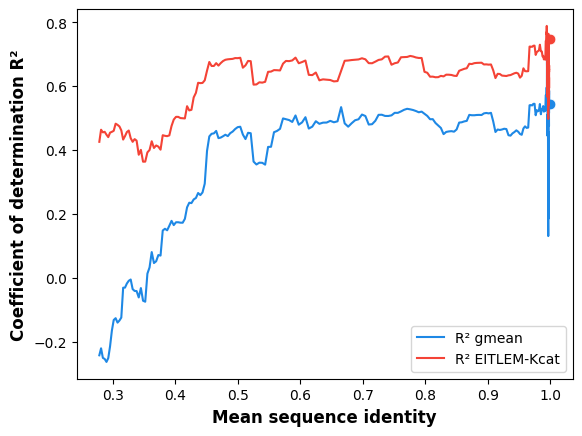

In [9]:
import sys
sys.path.append("../Code/")
from tools import metric
import numpy as np
import torch
import pandas as pd
from matplotlib import rc
from predictor import predict
import heapq
import copy
from sklearn.metrics import r2_score

def top3(t):
    m = copy.deepcopy(t)
    max_number = heapq.nlargest(3, m) 
    max_index = []
    for t in max_number:
        index = m.index(t)
        max_index.append(index)
        m[index] = 0
    return max_index

kineticsType = 'KCAT'

modelPath = {
    'KCAT':'../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787',
    'KM':'../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802',
    'KKM':'../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896'
}


test_pair_all = torch.load(f"../Data/{kineticsType}/{kineticsType}TestPairInfo")
train_pair = torch.load(f"../Data/{kineticsType}/{kineticsType}TrainPairInfo")
sim_data = torch.load(f"../Data/{kineticsType}/allseq_similarity.pt")


index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set



if kineticsType == 'KCAT':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
elif kineticsType == 'KM':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
else:
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

test_pair = []

for item in test_pair_all:
        seq = index_seq[item[0]]
        smiles = index_smiles[item[1]]
        if f"{seq}_{smiles}" not in ExcludeSet:
            test_pair.append(item)


y_true, y_pred = predict(
                kineticsType,
                modelPath[kineticsType],
                test_pair,
                f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                f"../Data/Feature/index_smiles",
                True,
                torch.device("cuda:1"),
                "MACCSKeys"
        )
# calculate gemo3
train_seq = set()
test_seq = set()
# [train_seq.add(item[0]) for item in train_pair]
[test_seq.add(item[0]) for item in test_pair]

train_pair_np = np.array([ item[:3] for item in train_pair])
test_seq_data = {}
index = np.array(sim_data['index'])
for item in test_seq:
    top3_index = index[top3(sim_data[item])]
    gemo3 = np.log10(train_pair_np[(train_pair_np[:,0] == top3_index[0])|(train_pair_np[:,0] == top3_index[1])|(train_pair_np[:,0] == top3_index[2])][:,2]).mean()
    test_seq_data[item] = [max(sim_data[item]), gemo3]
df_data = {'y_pred':[], 'y_test':[], 'gemo3':[], 'maxID':[]}

for i, item in enumerate(test_pair):
    df_data['y_pred'].append(y_pred[i])
    df_data['y_test'].append(y_true[i])
    df_data['gemo3'].append(test_seq_data[item[0]][1])
    df_data['maxID'].append(test_seq_data[item[0]][0])
df_data = pd.DataFrame(df_data)
win = 100
df_99 = df_data[df_data['maxID']<1]
df_sort = df_99.sort_values("maxID", ascending=False)
R2_slide =  pd.DataFrame(columns=["meanID", "R2.EITLEM", "R2.mean3"])
for i in range(df_sort.shape[0] - win + 1):
    df_i = df_sort.iloc[i:(i+win-1)]
    R2_slide.loc[i, "meanID"] = df_i["maxID"].mean()
    R2_slide.loc[i, "R2.EITLEM"] = r2_score(df_i["y_test"],df_i["y_pred"])
    R2_slide.loc[i, "R2.mean3"] = r2_score(df_i["y_test"], df_i["gemo3"])

df_100 = df_data[df_data['maxID']==1]

import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
# plt.rcParams.update({'font.size': 10})

R2_slide_long = pd.melt(R2_slide, id_vars="meanID")

sns.lineplot(x="meanID", y="value",  data=R2_slide_long.loc[R2_slide_long["variable"] == "R2.mean3"], color="#1E88E5",
             label = "R² gmean")
sns.lineplot(x="meanID", y="value", data=R2_slide_long.loc[R2_slide_long["variable"] == "R2.EITLEM"], color="#F44336",
            label = f"R² EITLEM-{kineticsType[:1]+kineticsType[1:].lower()}")
plt.xlabel("Mean sequence identity", weight='bold', size=12)
plt.ylabel("Coefficient of determination R²", weight='bold', size=12)
# plt.xlim(30, 108)
sns.scatterplot(x=[1.0],y=[r2_score(df_100['y_test'], df_100['gemo3'])], color="#1E88E5", s=60)
sns.scatterplot(x=[1.0],y=[r2_score(df_100['y_test'], df_100['y_pred'])], color="#F44336",s=60)

plt.savefig(f"./{kineticsType}_gmean_compare.png",dpi=600)
plt.show()

### Z-score

### Eitlem

In [10]:
import torch
import sys
sys.path.append("../Code/")
from predictor import predict
from tools import metric
import pandas as pd
import json
import math
import numpy as np
from collections import Counter
kineticsType = 'KCAT'
molType = 'MACCSKeys'
train_pair = [ [item[0], item[1], item[2], item[3][0]] for item in torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TrainPairInfo")]
test_pair = [ [item[0], item[1], item[2], item[3][0]] for item in torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TestPairInfo")]

index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

dataset_info = pd.read_json(f"../Data/{kineticsType.upper()}/{kineticsType.lower()}_data.json")
# with open(f"../Data/{kineticsType.upper()}/{kineticsType.lower()}_data.json", 'r') as f:
#     kinetics_data = json.load(f)

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    # index_seq = torch.load(f"../Data/{Type}/index_seq")
    # index_smiles = torch.load(f"../Data/{Type}/index_smiles")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set

if kineticsType == 'KCAT':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
elif kineticsType == 'KM':
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KKM', 'Train')
else:
    ExcludeSet = get_set(kineticsType.upper(), 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

ex_test_pair = []

for item in test_pair:
        seq = index_seq[item[0]]
        smiles = index_smiles[item[1]]
        if f"{seq}_{smiles}" not in ExcludeSet:
            ex_test_pair.append(item)

modelPath = {
    'KCAT':'../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787',
    'KM':'../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802',
    'KKM':'../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896'
}

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType.upper()}'],
                    test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
data_df = []
for pair_item, t, p in zip(test_pair, Real, Pre):
    dataItem = dataset_info.loc[pair_item[3]]
    k = f"{dataItem['ec']}_{dataItem['substrate']}_{dataItem['organism']}"
    data_df.append({
        'key':k,
        'Experimental':t,
        'Predicted':p,
        'Substrate':dataItem['substrate']
    })

data_df = pd.DataFrame(data_df)
data_df['choose'] = False
data_df['Experimental_zscaled'] = data_df['Experimental']
data_df['Predicted_zscaled'] = data_df['Predicted']

entry_dict = Counter(data_df['key'])
duplicated_dict = {key:value for key, value in entry_dict.items() if value > 1}
duplicated_list = sorted(duplicated_dict.items(), key=lambda x: x[1], reverse=True)[:10]

for k in duplicated_list:
    idx = (data_df['key'] == k[0])
    temp_df = data_df[idx]
    mean_value = temp_df['Experimental'].mean()
    std_value = temp_df['Experimental'].std()
    data_df.loc[idx, 'Experimental_zscaled'] = (data_df.loc[idx, 'Experimental'] - mean_value) / std_value
    data_df.loc[idx, 'Predicted_zscaled'] = (data_df.loc[idx, 'Predicted'] - mean_value) / std_value
    data_df.loc[idx, 'choose'] = True
data_df = data_df[data_df['choose']]
data_df = data_df[~(pd.isna(data_df['Experimental_zscaled'])|pd.isna(data_df['Predicted_zscaled']))]
result = metric(data_df['Predicted_zscaled'], data_df['Experimental_zscaled'], True)
print(result)

log10:True molType:MACCSKeys


100%|██████████| 35/35 [00:06<00:00,  5.23it/s]


{'MAE': 0.5232095693774942, 'rmse': 0.7244847758090391, 'r2': 0.21268271443138942, 'r': 0.609864176512571, 'p_value': 2.310898932616195e-07, 'samples': 60}


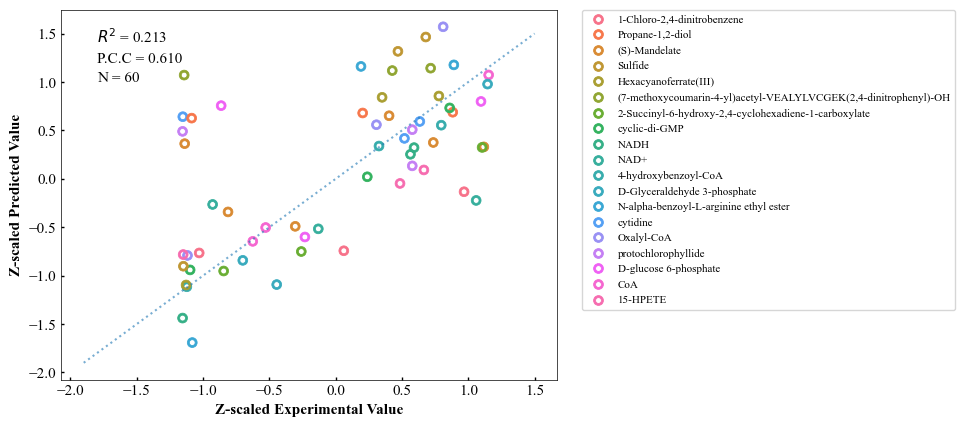

In [113]:

import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(np.arange(-1.9, 1.6, 0.1), np.arange(-1.9, 1.6,0.1), ":", linewidth=1.5, alpha=0.6)
plt.tick_params(direction='in')
plt.tick_params(which='major',length=2)
plt.tick_params(which='major',width=1)
sns.scatterplot(x="Experimental_zscaled", y="Predicted_zscaled", hue='Substrate',
                marker="$\circ$", ec="face", data=data_df, s= 50)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.yticks([0.5,0.7,0.9,1.1,1.3,1.5])
plt.xlabel('Z-scaled Experimental Value', fontsize=11, weight='bold')
plt.ylabel('Z-scaled Predicted Value', fontsize=11, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(frameon=False, prop={"size":12})

plt.text(-1.8, 1.4,'$R^{2}$ = %.3f' % result['r2'], fontweight ="normal", fontsize=11)
plt.text(-1.8, 1.2, 'P.C.C = %.3f' % result['r'], fontweight ="normal", fontsize=11)
plt.text(-1.8, 1.0,f'N = {len(data_df)}', fontweight ="normal", fontsize=11)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop={'size':8})
plt.savefig("./response_mutant_low20_effect_eitlem.png", dpi=600,bbox_inches='tight')

### UniKP

There are 30985 molecules. It will take a little time.
There are 3444 molecules. It will take a little time.
{'MAE': 0.8449910170456683, 'rmse': 1.148112204963202, 'r2': -0.9772424527781987, 'r': 0.3252688015897495, 'p_value': 0.011216215492949048, 'samples': 60}


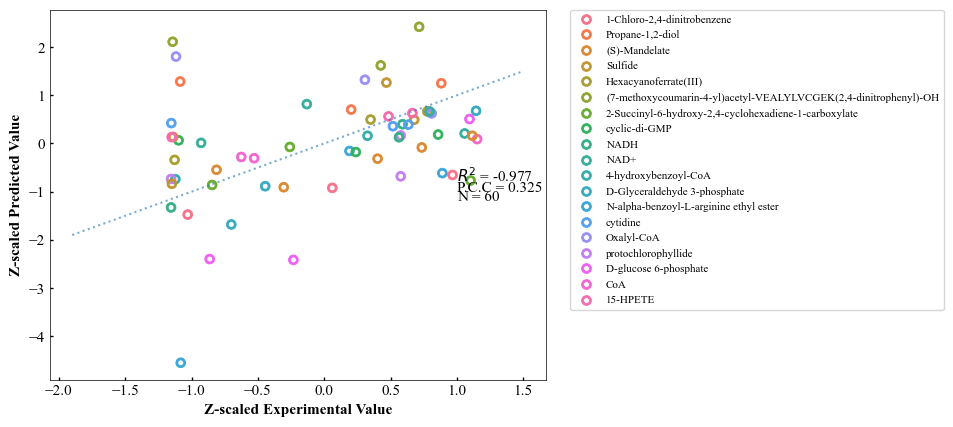

In [114]:
from UniKP import UniKp_predictor
from build_vocab import WordVocab
unikp_predictor = UniKp_predictor()
unikp_predictor.fit(train_pair, test_pair, index_seq, index_smiles, kineticsType)
x_test, Real = unikp_predictor._load_dataset(test_pair, unikp_predictor.index_seq, unikp_predictor.index_smiles)
Pre = unikp_predictor.model.predict(x_test)

data_df = []
for pair_item, t, p in zip(test_pair, Real, Pre):
    dataItem = dataset_info.loc[pair_item[3]]
    k = f"{dataItem['ec']}_{dataItem['substrate']}_{dataItem['organism']}"
    data_df.append({
        'key':k,
        'Experimental':t,
        'Predicted':p,
        'Substrate':dataItem['substrate']
    })

data_df = pd.DataFrame(data_df)
data_df['choose'] = False
data_df['Experimental_zscaled'] = data_df['Experimental']
data_df['Predicted_zscaled'] = data_df['Predicted']

entry_dict = Counter(data_df['key'])
duplicated_dict = {key:value for key, value in entry_dict.items() if value > 2}
duplicated_list = sorted(duplicated_dict.items(), key=lambda x: x[1], reverse=False)[:20]

for k in duplicated_list:
    idx = (data_df['key'] == k[0])
    temp_df = data_df[idx]
    mean_value = temp_df['Experimental'].mean()
    std_value = temp_df['Experimental'].std()
    data_df.loc[idx, 'Experimental_zscaled'] = (data_df.loc[idx, 'Experimental'] - mean_value) / std_value
    data_df.loc[idx, 'Predicted_zscaled'] = (data_df.loc[idx, 'Predicted'] - mean_value) / std_value
    data_df.loc[idx, 'choose'] = True
data_df = data_df[data_df['choose']]
data_df = data_df[~(pd.isna(data_df['Experimental_zscaled'])|pd.isna(data_df['Predicted_zscaled']))]
result = metric(data_df['Predicted_zscaled'], data_df['Experimental_zscaled'], True)
print(result)

import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(np.arange(-1.9, 1.6, 0.1), np.arange(-1.9, 1.6,0.1), ":", linewidth=1.5, alpha=0.6)
plt.tick_params(direction='in')
plt.tick_params(which='major',length=2)
plt.tick_params(which='major',width=1)
sns.scatterplot(x="Experimental_zscaled", y="Predicted_zscaled", hue='Substrate',
                marker="$\circ$", ec="face", data=data_df, s= 50)
plt.rcParams['font.family'] = 'Times New Roman'
# plt.yticks([0.5,0.7,0.9,1.1,1.3,1.5])
plt.xlabel('Z-scaled Experimental Value', fontsize=11, weight='bold')
plt.ylabel('Z-scaled Predicted Value', fontsize=11, weight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(frameon=False, prop={"size":12})

plt.text(0.5, -2,'$R^{2}$ = %.3f' % result['r2'], fontweight ="normal", fontsize=11)
plt.text(0.5, -2.5, 'P.C.C = %.3f' % result['r'], fontweight ="normal", fontsize=11)
plt.text(0.5, -3.,f'N = {len(data_df)}', fontweight ="normal", fontsize=11)
ax = plt.gca()
ax.spines['bottom'].set_linewidth(0.5)
ax.spines['left'].set_linewidth(0.5)
ax.spines['top'].set_linewidth(0.5)
ax.spines['right'].set_linewidth(0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop={'size':8})
plt.savefig("./response_mutant_effect_low20_unikp.png", dpi=600,bbox_inches='tight')

### predict KKm with trained kcat model and trained km model

log10:True molType:MACCSKeys


100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


log10:True molType:MACCSKeys
F


100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


{'MAE': 0.8927308551159564, 'rmse': 1.3557464075367596, 'r2': 0.4111665434385873, 'r': 0.667534213734696, 'p_value': 1.1659592637184285e-56, 'samples': 429}


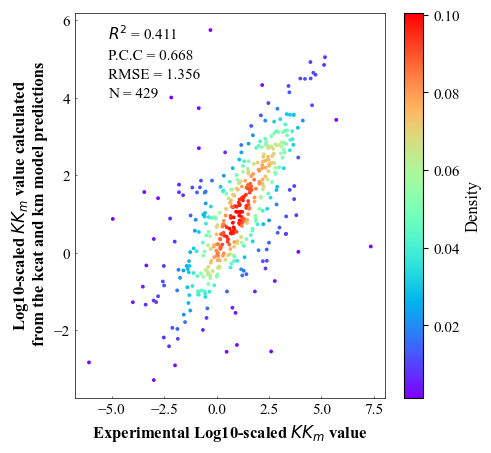

In [1]:
import torch
import sys
sys.path.append("../Code/")
from predictor import predict
from tools import metric, drawScatter
import pandas as pd
import json
import math
import numpy as np
import math
modelPath = {
    'KCAT':'../Weights/KCAT/iter1_trainR2_0.9166_devR2_0.6752_RMSE_0.8763_MAE_0.5617',
    'KM':'../Weights/KM/iter1_trainR2_0.8980_devR2_0.6307_RMSE_0.7941_MAE_0.5537'
}
### 加载KKM数据
pair_info = torch.load("../Data/KKM/KKMTestPairInfo")
index_seq = torch.load("../Data/Feature/index_seq")
index_smiles = torch.load("../Data/Feature/index_smiles")


def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set


ExcludeSet = get_set('KKM', 'Test') & get_set('KCAT', 'Train') & get_set('KM', 'Train')

ex_test_pair = []

for item in pair_info:
    seq = index_seq[item[0]]
    smiles = index_smiles[item[1]]
    if f"{seq}_{smiles}" not in ExcludeSet:
        ex_test_pair.append(item)

### Kcat预测
Real, kcat_Pre = predict(
                    "KCAT",
                    modelPath['KCAT'],
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )

### Km预测
Real, km_Pre = predict(
                    "KM",
                    modelPath['KM'],
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )




### 拟合kkm
kkm_pre = []
for kcat, km in zip(kcat_Pre, km_Pre):
    kkm_pre.append(math.log10(math.pow(10, kcat) / math.pow(10, km)))
    
Result = metric(kkm_pre, Real, True)
print(Result)
### Draw

drawScatter(Real, 
            kkm_pre, 
            Result, 
            position = [[-5.2, 5.5], 
                        [-5.2, 5.0], 
                        [-5.2, 4.5], 
                        [-5.2, 4]],
            xlabel = "Experimental Log10-scaled $KK_{m}$ value",
            ylabel = "Log10-scaled $KK_{m}$ value calculated \n from the kcat and km model predictions",
            save_path = f"./Response-KKM-with-kcat_km-prediction.png"
            )

## Ensemble Denovo Train

log10:False molType:MACCSKeys


100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


{'MAE': 0.8299259860468361, 'rmse': 1.2258674482286231, 'r2': 0.5185817142967024, 'r': 0.7371808562978338, 'p_value': 1.0513200918527464e-74, 'samples': 429}


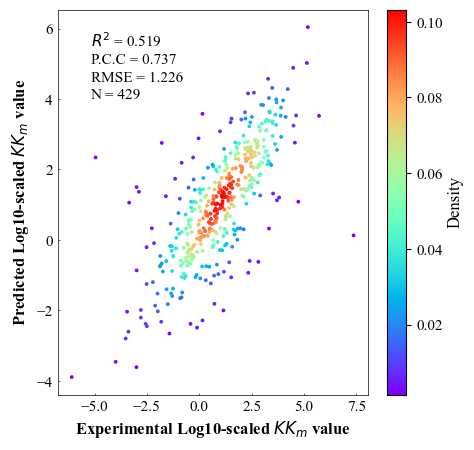

In [2]:

Real, Pre = predict(
                    "KKM",
                    "../Weights/KKM/BaseKKmPredictor_trainR2_0.8425_devR2_0.5885_RMSE_1.1471_MAE_0.8049",
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    False,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
Result = metric(Pre, Real, False)
print(Result)
Pre = np.log10(np.power(2, Pre))
Real = np.log10(np.power(2, Real))

drawScatter(Real, 
            Pre, 
            Result, 
            position = [[-5.2, 5.5], 
                        [-5.2, 5.0], 
                        [-5.2, 4.5], 
                        [-5.2, 4]],
            xlabel = "Experimental Log10-scaled $KK_{m}$ value",
            ylabel = "Predicted Log10-scaled $KK_{m}$ value",
            save_path = f"./Response-KKM-Ensemble-Denovo.png"
            )

### KKMP denovo

log10:False molType:MACCSKeys


100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


{'MAE': 0.8306815957702781, 'rmse': 1.1849647945352606, 'r2': 0.5501720348331631, 'r': 0.7700666981998336, 'p_value': 2.223505593751757e-85, 'samples': 429}


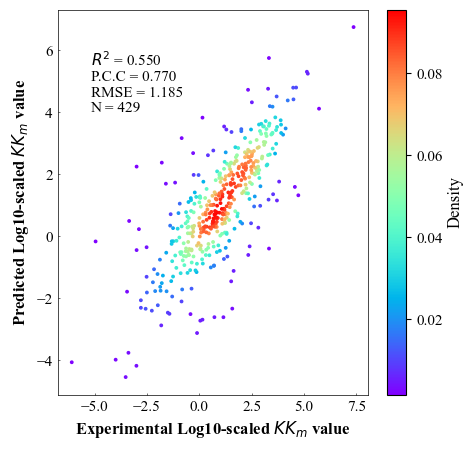

In [3]:
Real, Pre = predict(
                    "KKMP",
                    "../Weights/KKM/kkmp_denovo_trainR2_0.8893_devR2_0.6136_RMSE_1.1116_MAE_0.7944",
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    False,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
Result = metric(Pre, Real, False)
print(Result)
Pre = np.log10(np.power(2, Pre))
Real = np.log10(np.power(2, Real))

drawScatter(Real, 
            Pre, 
            Result, 
            position = [[-5.2, 5.5], 
                        [-5.2, 5.0], 
                        [-5.2, 4.5], 
                        [-5.2, 4]],
            xlabel = "Experimental Log10-scaled $KK_{m}$ value",
            ylabel = "Predicted Log10-scaled $KK_{m}$ value",
            save_path = f"./Response-KKMP-Denovo.png"
            )

### Ensemble KKMP FineTune 1

log10:True molType:MACCSKeys


100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


{'MAE': 0.6847750600601062, 'rmse': 1.0140356918356788, 'r2': 0.6705860123961299, 'r': 0.8191198933375097, 'p_value': 4.0360708940699025e-105, 'samples': 429}


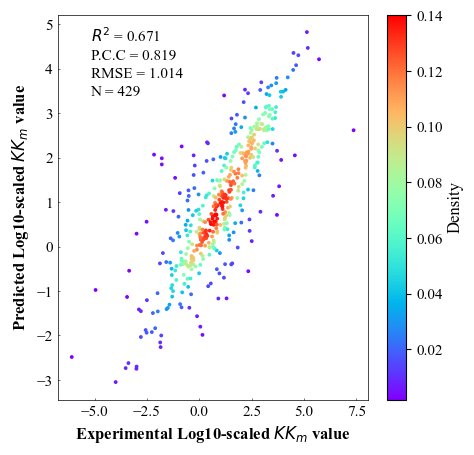

In [12]:
Real, Pre = predict(
                    "KKM",
                    "../Weights/KKM/transfer-trainR2_0.9212_devR2_0.8002_RMSE_0.8102_MAE_0.5650",
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
Result = metric(Pre, Real, True)
print(Result)
# Pre = np.log10(np.power(2, Pre))
# Real = np.log10(np.power(2, Real))


drawScatter(Real, 
            Pre, 
            Result, 
            position = [[-5.2,4.6], 
                        [-5.2,4.2], 
                        [-5.2,3.8], 
                        [-5.2,3.4]],
            xlabel = "Experimental Log10-scaled $KK_{m}$ value",
            ylabel = "Predicted Log10-scaled $KK_{m}$ value",
            save_path = f"./Response-KKM-FinTune.png"
            )

log10:False molType:MACCSKeys


100%|██████████| 5/5 [00:05<00:00,  1.15s/it]


{'MAE': 0.8658819726232182, 'rmse': 1.27047895172514, 'r2': 0.4829048016187938, 'r': 0.6991539686776329, 'p_value': 3.326907156459825e-64, 'samples': 429}


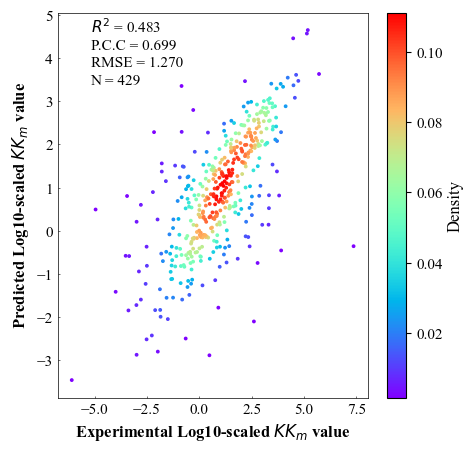

In [14]:
### Ensemble Frozen
Real, Pre = predict(
                    "KKM",
                    "../Weights/KKM/Ensemble_Frozen_train_trainR2_0.5916_devR2_0.6508_RMSE_1.0566_MAE_0.6669",
                    ex_test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    False,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
Result = metric(Pre, Real, False)
print(Result)
Pre = np.log10(np.power(2, Pre))
Real = np.log10(np.power(2, Real))


drawScatter(Real, 
            Pre, 
            Result, 
            position = [[-5.2,4.6], 
                        [-5.2,4.2], 
                        [-5.2,3.8], 
                        [-5.2,3.4]],
            xlabel = "Experimental Log10-scaled $KK_{m}$ value",
            ylabel = "Predicted Log10-scaled $KK_{m}$ value",
            save_path = f"./Response-ensemnble_frozen.png"
            )

### Different smiles

In [11]:
import torch
index_smiles = torch.load("../Data/Feature/index_smiles")
complex_smiles = {}
pair = torch.load("../Data/KCAT/KCATTestPairInfo")
for item in pair:
    if '.' in index_smiles[item[1]] and item[1] not in complex_smiles:
        complex_smiles[item[1]] = index_smiles[item[1]]
# print(complex_smiles)

In [12]:
complex_smiles = {
    "origin":{
        4926: '[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Fe+3]',
        7140: 'N.OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O',
        110: 'Nc1ncnc2c1ncn2[C@@H]1O[C@H](COP(=O)(O)OP(=O)(O)OP(=O)(O[Na])O[Na])[C@@H](O)[C@H]1O.O.O.O',
        5802: 'O=P([O-])(O)O[C@@H]1[C@@H](OP(=O)(O)O)[C@H](OP(=O)([O-])O)[C@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)[C@H]1OP(=O)(O)O.[Na+].[Na+]',
        1927: 'O.OC[C@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@H]1O',
        2743: 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)c2cc1C.[Na+].[Na+]',
        5653: 'Cn1c(=O)c2c(ncn2C)n(C)c1=O.O',
        5331: 'Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1.[Cl-]',
        3536: 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COP(=O)([O-])[O-].[Na+].[Na+]',
        912: 'Nc1ncnc2c1ncn2[C@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O.[Mg+2]',
        1254: '[Fe+2].c1cc[cH-]c1.c1cc[cH-]c1',
        5996: 'CNC(=O)C(N)CSC(C)C1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)O)C(CCC(=O)O)=C4C)c(C)c3C(C)SCC(N)C(=O)NC.[Fe+2]',
        5772: 'CC1=C2N=C(C=C3N=C(C(C)=C4[N-]C(C(CC(N)=O)C4(C)CCC(=O)NCC(C)OP(=O)([O-])OC4C(CO)OC(n5cnc6cc(C)c(C)cc65)C4O)C4(C)N=C1C(CCC(N)=O)C4(C)CC(N)=O)C(CCC(N)=O)C3(C)C)C(CCC(N)=O)C2(C)CC(N)=O.[Co]',
        124: 'CC(=O)O.O=CC(O)C(O)C(O)C(O)CO',
        4175: 'CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1.O',
        2768: 'O=[N+]([O-])c1ccccc1OC1OC(COP(=O)(O)O)C(O)C(O)C1O.[NH3+]C1CCCCC1',
    },
    "deion":{
        4926: '[C-]#N',
        5802: 'O=P([O-])(O)O[C@@H]1[C@@H](OP(=O)(O)O)[C@H](OP(=O)([O-])O)[C@H](OP(=O)(O)O)[C@H](OP(=O)(O)O)[C@H]1OP(=O)(O)O',
        2743: 'Cc1cc2nc3c(=O)[nH]c(=O)nc-3n(C[C@H](O)[C@H](O)[C@H](O)COP(=O)([O-])OP(=O)([O-])OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)c2cc1C',
        7140: 'OCC1OC(OC2C(CO)OC(O)C(O)C2O)C(O)C(O)C1O',
        1927: 'OC[C@H]1O[C@@H](O[C@H]2[C@H](O)[C@@H](O)[C@@H](O)O[C@@H]2CO)[C@H](O)[C@@H](O)[C@H]1O',
        5653: 'Cn1c(=O)c2c(ncn2C)n(C)c1=O',
        5331: 'Cc1ncc(C[n+]2csc(CCO)c2C)c(N)n1',
        3536: 'C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@@]3(F)[C@@H](O)C[C@]2(C)[C@@]1(O)C(=O)COP(=O)([O-])[O-]',
        912: 'Nc1ncnc2c1ncn2[C@H]1O[C@H](COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])[C@@H](O)[C@H]1O',
        1254: 'c1cc[cH-]c1',
        5996: 'CNC(=O)C(N)CSC(C)C1=C(C)c2cc3[n-]c(cc4nc(cc5[n-]c(cc1n2)c(C)c5CCC(=O)O)C(CCC(=O)O)=C4C)c(C)c3C(C)SCC(N)C(=O)NC',
        5772: 'CC1=C2N=C(C=C3N=C(C(C)=C4[N-]C(C(CC(N)=O)C4(C)CCC(=O)NCC(C)OP(=O)([O-])OC4C(CO)OC(n5cnc6cc(C)c(C)cc65)C4O)C4(C)N=C1C(CCC(N)=O)C4(C)CC(N)=O)C(CCC(N)=O)C3(C)C)C(CCC(N)=O)C2(C)CC(N)=O',
        4175: 'CC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)[C@H](N)c3ccccc3)[C@H]2SC1',
    },
    "desubs_1":{
        124: 'CC(=O)O',
        2768: '[NH3+]C1CCCCC1'
    },
    "desubs_2":{
        124: 'O=CC(O)C(O)C(O)C(O)CO',
        2768: 'O=[N+]([O-])c1ccccc1OC1OC(COP(=O)(O)O)C(O)C(O)C1O'
    }
 }

In [14]:
### get pair
deion_pair = []
for item in pair:
    if item[1] in complex_smiles['deion']:
        deion_pair.append(item)

In [15]:
import sys
sys.path.append("../Code/")
from tools import metric
import numpy as np
import torch    
import pandas as pd
from predictor import predict
from scipy import stats
def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^20}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")
## deion
origin_Real, origin_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    deion_pair,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    complex_smiles['origin'],
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
deion_Real, deion_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    deion_pair,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    complex_smiles['deion'],
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
print(f"|{'Subs Type':^20}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("deion origin",**metric(origin_Pre, origin_Real, True))
printf("deion ",**metric(deion_Pre, deion_Real, True))

print(stats.wilcoxon(np.abs(np.array(deion_Pre)-np.array(deion_Real)), np.abs(np.array(origin_Pre)-np.array(origin_Real)),alternative='two-sided'))

log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

|     Subs Type      | MAE  | rmse |  r2  |  r   |p_value |samples |
|    deion origin    |0.402 |0.730 |0.871 |0.935 | 0.000  |   28   |
|       deion        |0.508 |0.886 |0.810 |0.903 | 0.000  |   28   |
WilcoxonResult(statistic=197.0, pvalue=0.9018996506929398)


In [19]:
### desubs
origin_Real, origin_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    desubs_pair,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    complex_smiles['origin'],
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
desubs_Real, desubs_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    desubs_pair,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    complex_smiles['desubs_2'],
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
print(f"|{'Subs Type':^20}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("desubs origin",**metric(origin_Pre, origin_Real, True))
printf("desubs 1",**metric(desubs_Pre, desubs_Real, True))
print(stats.wilcoxon(np.abs(np.array(desubs_Pre)-np.array(desubs_Real)), np.abs(np.array(origin_Pre)-np.array(origin_Real)), alternative='two-sided'))

log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

|     Subs Type      | MAE  | rmse |  r2  |  r   |p_value |samples |
|   desubs origin    |1.934 |3.137 |-5.863|0.088 | 0.912  |   4    |
|      desubs 1      |2.002 |3.113 |-5.759|0.038 | 0.962  |   4    |
WilcoxonResult(statistic=3.0, pvalue=0.625)


#### 2. All substrates

In [42]:
from collections import defaultdict
def mapPair_for_subs(pair_info):
    new_info = []
    origin_pair = []
    all_subs_index = defaultdict(lambda:len(all_subs_index))
    for item in pair_info:
        meta_info = dataset_info.loc[item[3][0]]
        subs_name = meta_info['substrate'].lower()
        sub_rnx = rnx_info[rnx_info['EC'] == meta_info['ec']]
        if len(sub_rnx) == 0:
            continue
        if len(sub_rnx) == 1:
            new_info.append([item[0], all_subs_index[list(sub_rnx['rnx'])[0].split('>>')[0]], item[2]])
            origin_pair.append(item)
        else:
            flag = -1
            for idx, eqo in enumerate(sub_rnx['Equation']):
                if subs_name in eqo.lower():
                    flag = idx
                    break
            if flag != -1:
                new_info.append([item[0], all_subs_index[list(sub_rnx['rnx'])[idx].split('>>')[0]], item[2]])
                origin_pair.append(item)
            else:
                new_info.append([item[0], all_subs_index[meta_info['smiles']], item[2]])
                origin_pair.append(item)
    all_subs_index = dict(all_subs_index)
    subs_index = {v:k for k, v in all_subs_index.items()}
    return new_info, origin_pair, subs_index

test_pair_allsubs, test_pair_singlepair, allsubs_index = mapPair_for_subs(test_pair)

In [43]:
import sys
sys.path.append("../Code/")
from tools import metric
import numpy as np
import torch    
import pandas as pd
from predictor import predict
from scipy import stats
def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^20}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")
## deion
origin_Real, origin_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    test_pair_singlepair,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    "../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
all_Real, all_Pre = predict(
                    "KCAT",
                    "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                    test_pair_allsubs,
                    "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    allsubs_index,
                    True,
                    torch.device("cuda:1"),
                    "MACCSKeys"
                   )
print(f"|{'Subs Type':^20}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
printf("single subs",**metric(origin_Pre, origin_Real, True))
printf("all subs",**metric(all_Pre, all_Real, True))
print(stats.wilcoxon(np.abs(np.array(all_Pre)-np.array(all_Real)), np.abs(np.array(origin_Pre)-np.array(origin_Real)), alternative='two-sided'))

log10:True molType:MACCSKeys


100%|██████████| 28/28 [00:07<00:00,  3.71it/s]


log10:True molType:MACCSKeys


100%|██████████| 28/28 [00:08<00:00,  3.27it/s]

|     Subs Type      | MAE  | rmse |  r2  |  r   |p_value |samples |
|    single subs     |0.474 |0.772 |0.746 |0.865 | 0.000  |  2775  |
|      all subs      |0.615 |0.934 |0.627 |0.799 | 0.000  |  2775  |
WilcoxonResult(statistic=1046060.0, pvalue=5.275734749435276e-49)


### Strict evaluation

In [28]:
import sys
sys.path.append("../Code/")
import torch
import os
from tools import getPairInfo
from tools import metric, drawScatter
from predictor import predict
from UniKP import UniKp_predictor
from build_vocab import WordVocab

def mapPair_strict(pair_info):
    origin_pair = []
    for item in pair_info:
        meta_info = dataset_info.loc[item[3][0]]
        subs_name = meta_info['substrate'].lower()
        sub_rnx = rnx_info[rnx_info['EC'] == meta_info['ec']]
        if len(sub_rnx) == 0:
            continue
        if len(sub_rnx) == 1:
            # new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[0], item[2]])
            origin_pair.append(item)
        else:
            flag = -1
            for idx, eqo in enumerate(sub_rnx['Equation']):
                if subs_name in eqo.lower():
                    flag = idx
                    break
            if flag != -1:
                # new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[idx], item[2]])
                origin_pair.append(item)
            else:
                # new_info.append([meta_info['sequence'], list(sub_rnx['rnx'])[0], item[2]])
                origin_pair.append(item)
    return origin_pair

def TurNupPredict(enz_model, rxn_model, pair):
    pair = mapPair(pair)
    x_seq, x_rxn, y = loadTurNupDataset(pair, torch.device("cuda:0"))
    y_test_pred = (enz_model.predict(xgb.DMatrix(x_seq)) + rxn_model.predict(xgb.DMatrix(x_rxn)))/2
    return metric(y_test_pred, y), (y_test_pred, y)

def EitlemPredict(pair):
    Real, Pre = predict(
                        "KCAT",
                        "../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
                        pair,
                        "../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                        "../Data/Feature/index_smiles",
                        True,
                        torch.device("cuda:1"),
                        "MACCSKeys"
                    )
    
    return metric(Pre, Real), (Pre, Real)

def UniKpPredict(pair):
    unikp_predictor = UniKp_predictor()
    unikp_predictor.fit(train_pair, train_pair + test_pair, index_seq, index_smiles, "KCAT")
    return unikp_predictor.test(pair, True)

def get_set(Type, Stage):
    pair_info = torch.load(f"../Data/{Type}/{Type}{Stage}PairInfo")
    pair_set = set()
    for item in pair_info:
        pair_set.add(f"{index_seq[item[0]]}_{index_smiles[item[1]]}")
    return pair_set

def get_range_pair(low, high, m_sim_index, s_sim_index, pair, strict=False):
    pairInfo = []
    for item in pair:
        try:
            t  = s_sim_index[item[0]]
        except:
            t = 1.0
        
        x = m_sim_index[item[1]]
        if not strict:
            if t < 0.95 or x < 1.0:
                pairInfo.append(item)
        else:
            if t < 0.95 and x < 1.0:
                pairInfo.append(item)
    return pairInfo

def printf(range, MAE, rmse, r2, r, p_value, samples):
    print(f"|{range:^60}|{MAE:^6.3f}|{rmse:^6.3f}|{r2:^6.3f}|{r:^6.3f}|{p_value:^8.3f}|{samples:^8}|")

In [33]:
test_pair = torch.load("../Data/KCAT/KCATTestPairInfo")
train_pair = torch.load("../Data/KCAT/KCATTrainPairInfo")
index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")
ExcludeSet = get_set("KCAT", 'Test') & get_set('KM', 'Train') & get_set('KKM', 'Train')
exclude_test_pairinfo = []
for item in test_pair:
    seq = index_seq[item[0]]
    smiles = index_smiles[item[1]]
    if f"{seq}_{smiles}" not in ExcludeSet:
        exclude_test_pairinfo.append(item)
exclude_test_pairinfo = mapPair_strict(exclude_test_pairinfo)
seqs_sim_index = torch.load(f"../Data/KCAT/all_seq_Indentity.pt")
seqs_sim_index = {k:max(v) for k, v in seqs_sim_index.items()}
## 获取底物相似性
torch.save(test_pair, "./query")
torch.save(train_pair, "./search")
cmd = f"python ../Code/calculate_similarity.py -m True -q ./query -s ./search -f ../Data/Feature/index_smiles"
os.system(cmd)
subs_sim_index = torch.load("./molSimiResults")

326 query entrys 
 5731 search entrys


In [35]:
import xgboost as xgb
enz_model = torch.load("../Weights/TurNup/seq_bst_hp")
rxn_model = torch.load("../Weights/TurNup/rxn_bst_hp")
print(f"|{'Desc':^60}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
p_t, v_t = TurNupPredict(enz_model, rxn_model, get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo))
printf("TurNup's performance in 95% max similarity:",**p_t)
p_u, v_u = UniKpPredict(get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo))
printf("UniKp's performance in 95% max similarity:",**p_u)
p_e, v_e = EitlemPredict(get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo))
printf("Eitlem's performance in 95% max similarity:",**p_e)

|                            Desc                            | MAE  | rmse |  r2  |  r   |p_value |samples |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


117/195|        TurNup's performance in 95% max similarity:         |0.938 |1.197 |0.477 |0.704 | 0.000  |  215   |
There are 30985 molecules. It will take a little time.
There are 215 molecules. It will take a little time.
|         UniKp's performance in 95% max similarity:         |0.879 |1.192 |0.481 |0.709 | 0.000  |  215   |
log10:True molType:MACCSKeys


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]

|        Eitlem's performance in 95% max similarity:         |0.774 |1.115 |0.546 |0.742 | 0.000  |  215   |


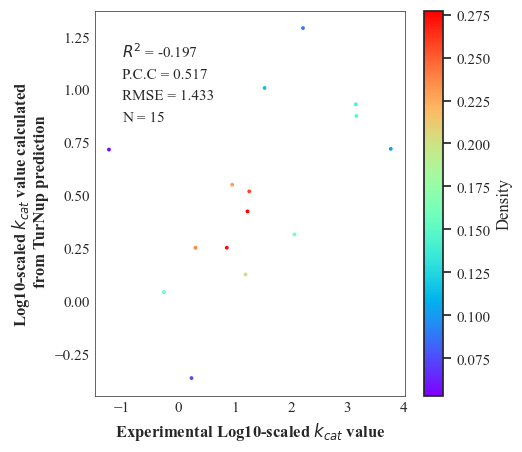

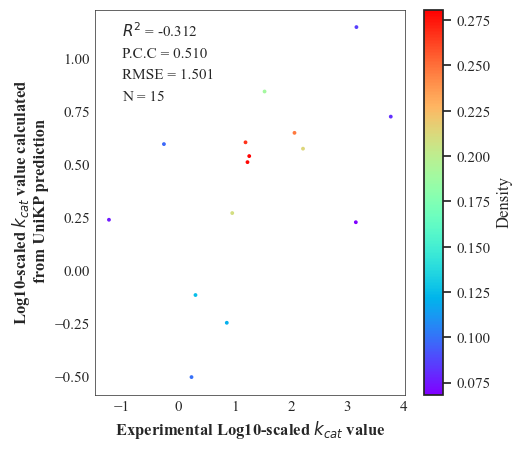

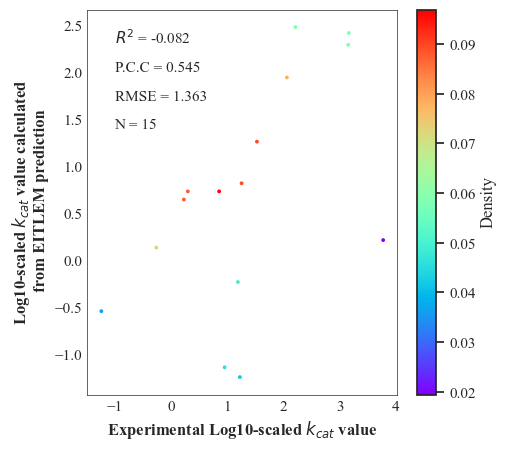

In [47]:
%matplotlib inline
sns.set_style(style="white")
drawScatter(v_t[1], 
            v_t[0], 
            p_t, 
            position = [[-1., 1.15], 
                        [-1, 1.05], 
                        [-1, 0.95], 
                        [-1, 0.85]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from TurNup prediction",
            save_path = f"./Response-round2-TurNup-95-prediction.png"
            )
drawScatter(v_u[1], 
            v_u[0], 
            p_u, 
            position = [[-1., 1.10], 
                        [-1, 1.0], 
                        [-1, 0.9], 
                        [-1, 0.8]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from UniKP prediction",
            save_path = f"./Response-round2-UniKP-95-prediction.png"
            )
drawScatter(v_e[1], 
            v_e[0], 
            p_e, 
            position = [[-1., 2.3], 
                        [-1, 2.0], 
                        [-1, 1.7], 
                        [-1, 1.4]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from EITLEM prediction",
            save_path = f"./Response-round2-EITLEM-95-prediction.png"
            )

In [39]:
print(f"|{'Desc':^60}|{'MAE':^6}|{'rmse':^6}|{'r2':^6}|{'r':^6}|{'p_value':^8}|{'samples':^8}|")
p_t, v_t = TurNupPredict(enz_model, rxn_model, get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo, strict=True))
printf("TurNup's performance in 95% max similarity:",**p_t)
p_u, v_u = UniKpPredict(get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo, strict=True))
printf("UniKp's performance in 95% max similarity:",**p_u)
p_e, v_e = EitlemPredict(get_range_pair(0., 0.95, subs_sim_index, seqs_sim_index, exclude_test_pairinfo, strict=True))
printf("Eitlem's performance in 95% max similarity:",**p_e)

|                            Desc                            | MAE  | rmse |  r2  |  r   |p_value |samples |


/home/sxw/anaconda3/envs/dl/lib/python3.10/site-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


|        TurNup's performance in 95% max similarity:         |1.153 |1.433 |-0.197|0.517 | 0.048  |   15   |
There are 30985 molecules. It will take a little time.
|         UniKp's performance in 95% max similarity:         |1.269 |1.501 |-0.312|0.510 | 0.052  |   15   |
log10:True molType:MACCSKeys


100%|██████████| 1/1 [00:05<00:00,  5.08s/it]

|        Eitlem's performance in 95% max similarity:         |0.954 |1.363 |-0.082|0.545 | 0.036  |   15   |


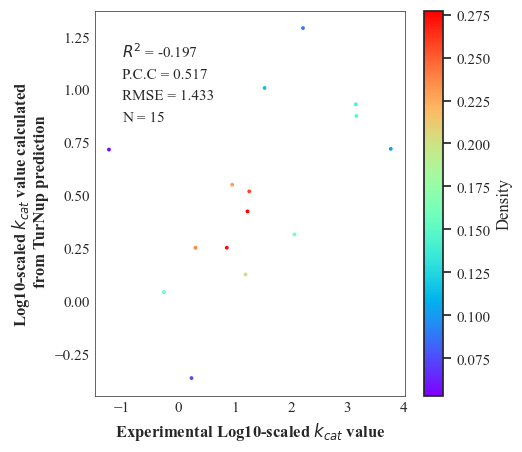

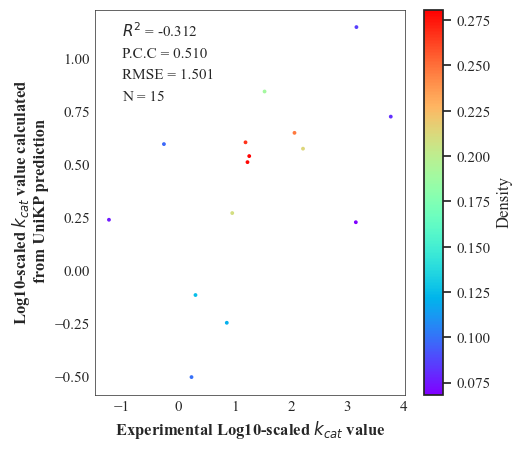

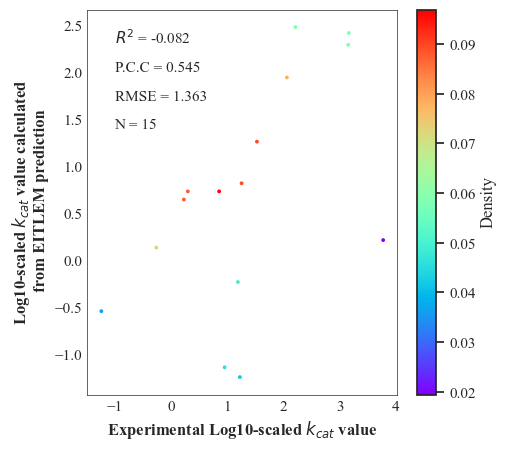

In [48]:
%matplotlib inline
drawScatter(v_t[1], 
            v_t[0], 
            p_t, 
            position = [[-1., 1.15], 
                        [-1, 1.05], 
                        [-1, 0.95], 
                        [-1, 0.85]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from TurNup prediction",
            save_path = f"./Response-round2-TurNup-95[enz-subs]-prediction.png"
            )
drawScatter(v_u[1], 
            v_u[0], 
            p_u, 
            position = [[-1., 1.10], 
                        [-1, 1.0], 
                        [-1, 0.9], 
                        [-1, 0.8]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from UniKP prediction",
            save_path = f"./Response-round2-UniKP-95[enz-subs]-prediction.png"
            )
drawScatter(v_e[1], 
            v_e[0], 
            p_e, 
            position = [[-1., 2.3], 
                        [-1, 2.0], 
                        [-1, 1.7], 
                        [-1, 1.4]],
            xlabel = "Experimental Log10-scaled $k_{cat}$ value",
            ylabel = "Log10-scaled $k_{cat}$ value calculated \n from EITLEM prediction",
            save_path = f"./Response-round2-EITLEM-95[enz-subs]-prediction.png"
            )

## Generate predicted results for test data sets.

In [3]:
import torch
import sys
import pandas as pd
sys.path.append("../Code/")
from predictor import predict
from tools import metric, getPairInfo

## 指定测试的动力学参数类型
kineticsType = 'kkm'
molType = 'MACCSKeys'

modelPath = {
    'kcat':"../Weights/KCAT/iter8_trainR2_0.9408_devR2_0.7459_RMSE_0.7751_MAE_0.4787",
    'km':"../Weights/KM/iter8_trainR2_0.9303_devR2_0.7163_RMSE_0.6960_MAE_0.4802",
    'kkm':"../Weights/KKM/iter8-trainR2_0.9091_devR2_0.8325_RMSE_0.7417_MAE_0.4896"
}

## 加载目标测试集
test_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TestPairInfo")
# train_pair = torch.load(f"../Data/{kineticsType.upper()}/{kineticsType.upper()}TrainPairInfo"
## 加载seq和smiles映射
index_seq = torch.load(f"../Data/Feature/index_seq")
index_smiles = torch.load(f"../Data/Feature/index_smiles")

Real, Pre = predict(
                    kineticsType.upper(),
                    modelPath[f'{kineticsType}'],
                    test_pair,
                    f"../Data/Feature/esm1v_t33_650M_UR90S_1_embeding_1280/",
                    f"../Data/Feature/index_smiles",
                    True,
                    torch.device("cuda:1"),
                    molType
                   )
print("metrics:",metric(Pre, Real, True))

result_df = {'seq':[], 'substrate':[], 'experimental value[log10]':[], 'predicted value[log10]':[]}
for pair, real, pred in zip(test_pair, Real, Pre):
    result_df['seq'].append(index_seq[pair[0]])
    result_df['substrate'].append(index_smiles[pair[1]])
    result_df['experimental value[log10]'].append(real)
    result_df['predicted value[log10]'].append(pred)
result_df = pd.DataFrame(result_df)
result_df.to_excel(f"../Data/{kineticsType.upper()}/{kineticsType}_test_results.xlsx")

log10:True molType:MACCSKeys


  0%|          | 0/14 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:04<00:00,  2.81it/s]


metrics: {'MAE': 0.5160755641959247, 'rmse': 0.7830887657866433, 'r2': 0.8082312656053501, 'r': 0.8998415990248418, 'p_value': 0.0, 'samples': 1345}
